## Vegan Restaurant Analysis in Kiel: Finding the Optimal Cluster with Minimal Competition 🌱🗺️

# Task 1 - Story

<div class="alert alert-block alert-info">
In this Notebook, I will investigate clusters of vegan restaurants around Kiel, and help new companies find the optimal cluster with minimal competition.
</div>

# Task 2 - The Data

In [325]:
import pandas as pd
import matplotlib.pyplot as plt

In [326]:
# importing data from csv file
# the data was querryed from an OpenStreetMap API in the gettingData.ipynb
data = pd.read_csv("data/restaurants_kiel.csv")

data.set_index("id", inplace=True)

The OpenStreetMap API returns an table of different restaurants and 122 attributes that are related to the restaurants.
To do this we need lattitute and longitude wich is represented in this dataset.

In [327]:
data.head(3)

,Unnamed: 0,type,lat,lon,addr:city,addr:country,addr:housenumber,addr:postcode,addr:street,amenity,...,changing_table:fee,drink:soy_milk,payment:electronic_purses,drink:coffee,bar,internet_access:ssid,currency:BCH,image,operator:type,note:de
id,,,,,,,,,,,,,,,,,,,,,
125623466,0,node,54.338116,10.128011,Kiel,DE,82,24118.0,Hansastraße,restaurant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125625723,1,node,54.337606,10.124073,Kiel,NaN,389,24118.0,Westring,cafe,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125626070,2,node,54.339351,10.123098,Kiel,NaN,2,24118.0,Rudolf-Höber-Straße,cafe,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Task 3 - IDA

## Geografical analysis

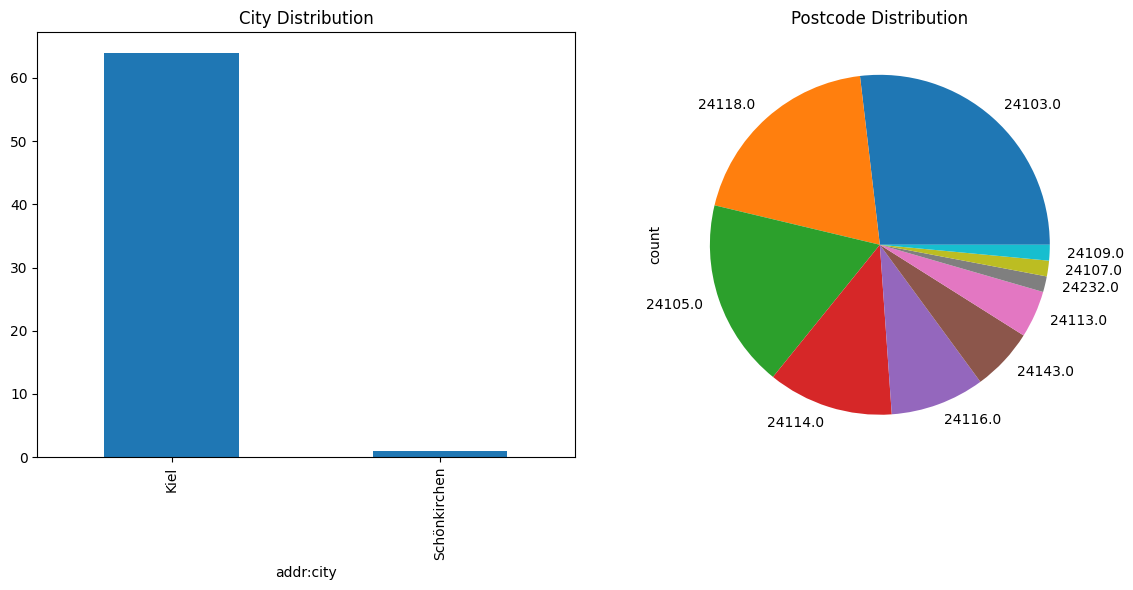

In [328]:
# Print the add:city distribution in a bar chart
plt.figure(figsize=(12, 6))  # Set the figure size as needed
plt.subplot(1, 2, 1)
plt.title('City Distribution')
data['addr:city'].value_counts().plot(kind='bar', ax=plt.gca())

# Print the add:postcode distribution in a pie chart
plt.subplot(1, 2, 2)
plt.title('Postcode Distribution')
data['addr:postcode'].value_counts().plot(kind='pie', ax=plt.gca())

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

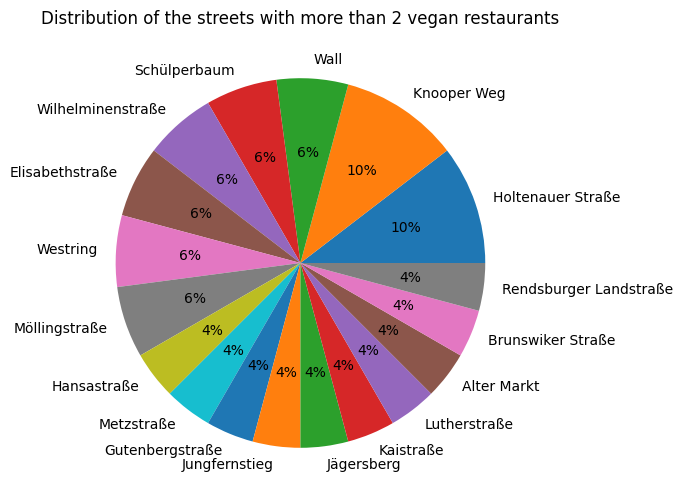

In [329]:
# Only return the values that are represented 2 or more times
data_filtered = data["addr:street"].value_counts()[data["addr:street"].value_counts() >= 2]

# Plot the pie chart with labels
plt.figure(figsize=(12, 6))  # Set the figure size as needed
data_filtered.plot.pie(autopct="%1.0f%%")
plt.title("Distribution of the streets with more than 2 vegan restaurants")
plt.ylabel("")
plt.show()

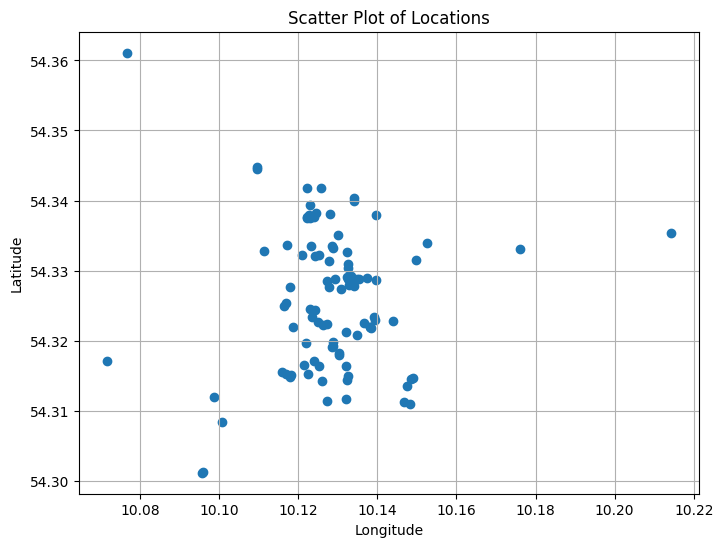

In [330]:
# Create a simple scatter plot
# TODO schön machen mit richtiger Karte :), vlt auch so daneben
plt.figure(figsize=(8, 6))
plt.scatter(data['lon'], data['lat'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot of Locations')
plt.grid(True)
plt.show()

In [331]:
# display statistical values about lat an lon
data[["lat", "lon"]].describe()

,lat,lon
count,96.000000,96.000000
mean,54.325829,10.128190
std,0.010236,0.016734
min,54.301161,10.071640
25%,54.317800,10.122422
50%,54.326405,10.128221
75%,54.332849,10.134093
max,54.361095,10.214153


## restaurant analysis

<Axes: title={'center': 'Cuisine Distribution'}, xlabel='cuisine'>

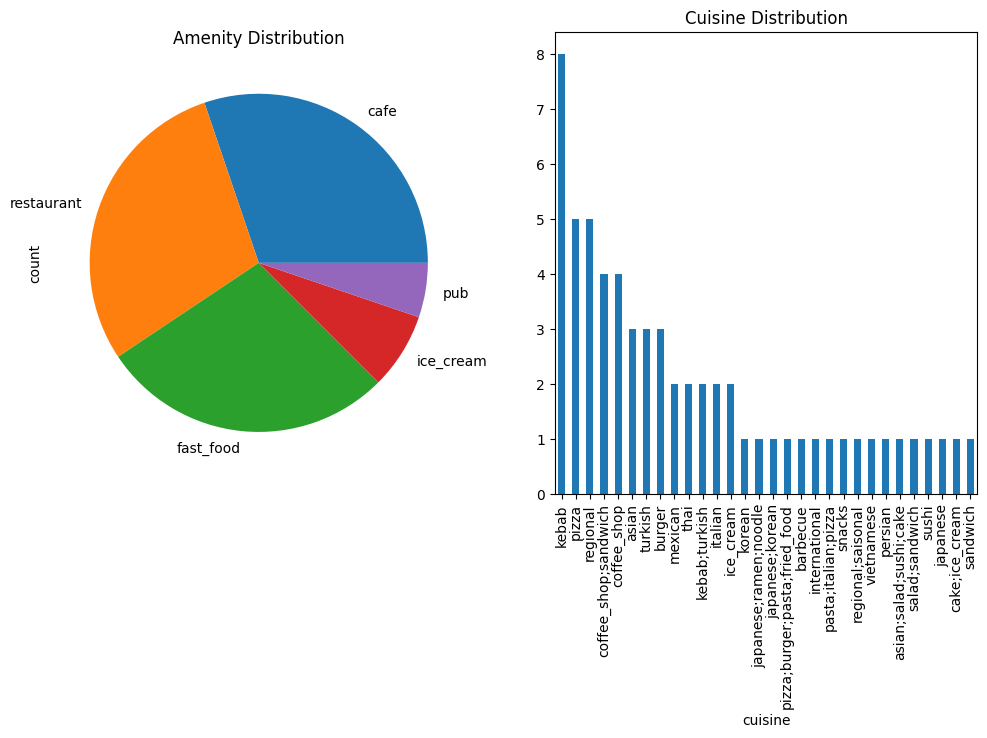

In [332]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Amenity Distribution")
plt.ylabel("")
data["amenity"].value_counts().plot(kind="pie", ax=plt.gca())

plt.subplot(1, 2, 2)
plt.title('Cuisine Distribution')
data["cuisine"].value_counts().plot(kind="bar", ax=plt.gca())

as we can see in the left graph above there are kinda equal ammount of fast_food, cafe and normal vegan restaurant distribution in kiel

<Axes: title={'center': 'Wheelchair accessibility in vegan restaurants'}, ylabel='count'>

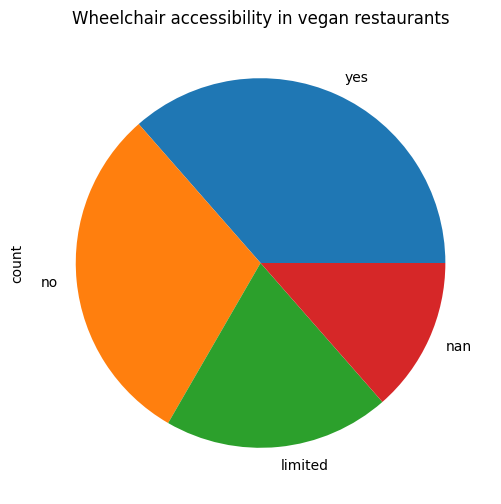

In [333]:
plt.figure(figsize=(12, 6))
plt.title('Wheelchair accessibility in vegan restaurants')
data["wheelchair"].value_counts(dropna=False).plot.pie()

this shows the distribution of wheelchare access, but the nan values have to be taken into consideration aswell

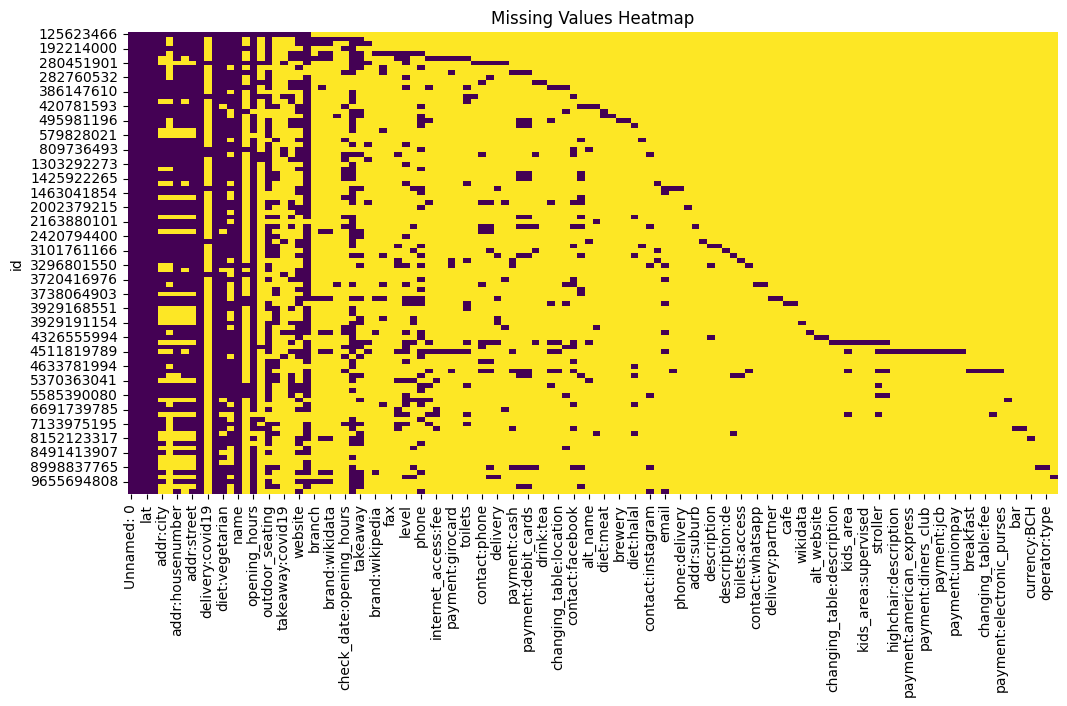

In [334]:
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.heatmap(data.isna(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

# inspired by https://stackoverflow.com/questions/47685905/matplotlib-heat-map-some-entries-missing-values

the heatmap above shows us what values are missing
on the y axis are different rows from the data
on the x axis are different attributes from the dataset

yellow entries represent a missing value of an attribute 
violette entries representing a present value of an attribute

on the left hand sinde we can see the attributes wich are commonly filled whil on the right hand sinde are mostly filled with nan values

In [335]:
# count na per attrobute of data

data.isna().sum().sort_values(ascending=True).head(10)

Unnamed: 0          0
type                0
lat                 0
name                0
amenity             0
diet:vegan          0
lon                 0
opening_hours       5
diet:vegetarian     8
wheelchair         13
dtype: int64

since open street map is a tool to display information on a UTM Map there are lat and lon values for every restaurant entry

looking at the lattitude and longitude we can see that there is a higher standard deriviation in lon so they are mor unequal on the y-axis on the map

# Task 4 - EDA and Preprocessing

# TODO: Outlyer Detection

In [336]:
# Since Unnamed: 0 is a index column, we will drop it
data.drop(columns=["Unnamed: 0"], inplace=True)

In [337]:
# since all attributes are from vegan restaurants and are nodes in OSM, we can drop the following columns
data.drop(columns=["type", "diet:vegan", "diet:vegetarian"], inplace=True)

In [338]:
# transforming wheelchair to categorical data
data["wheelchair"] = data["wheelchair"].astype("category")
data["amenity"] = data["amenity"].astype("category")

# Task 5 - Dimensionality Reduction

First of all we encode the non numeric values in our dataset as numeric labels that we can use for PCA

In [339]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
label_encoder = LabelEncoder()

# Copy the dataframe to avoid modifying the original data
restaurants_encoded_df = data.copy()

# Apply label encoding to non-numeric columns
non_numeric_columns = restaurants_encoded_df.select_dtypes(exclude=['number']).columns
restaurants_encoded_df[non_numeric_columns] = restaurants_encoded_df[non_numeric_columns].apply(lambda col: label_encoder.fit_transform(col.astype(str)), axis=0)

# Display the first few rows of the encoded dataframe
restaurants_encoded_df.head()

,lat,lon,addr:city,addr:country,addr:housenumber,addr:postcode,addr:street,amenity,delivery:covid19,indoor_seating,...,changing_table:fee,drink:soy_milk,payment:electronic_purses,drink:coffee,bar,internet_access:ssid,currency:BCH,image,operator:type,note:de
id,,,,,,,,,,,,,,,,,,,,,
125623466,54.338116,10.128011,0,0,53,24118.0,10,4,1,2,...,0,0,0,0,0,1,0,1,1,1
125625723,54.337606,10.124073,0,1,32,24118.0,40,0,0,2,...,0,0,0,0,0,1,0,1,1,1
125626070,54.339351,10.123098,0,1,16,24118.0,34,0,0,1,...,0,0,0,0,0,1,0,1,1,1
192214000,54.341774,10.125772,0,0,37,24118.0,40,4,0,2,...,0,0,0,0,0,1,0,1,1,1
268223175,54.322519,10.136583,0,1,27,24103.0,12,1,0,2,...,0,0,0,0,0,1,0,1,1,1


In [340]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

In [341]:
# Standardize the features
scaler = StandardScaler()
X_std = scaler.fit_transform(restaurants_encoded_df)


In [342]:
# Replace NaN values with the mean of the column
imputer = SimpleImputer(strategy='mean')
X_std_imputed = imputer.fit_transform(X_std)


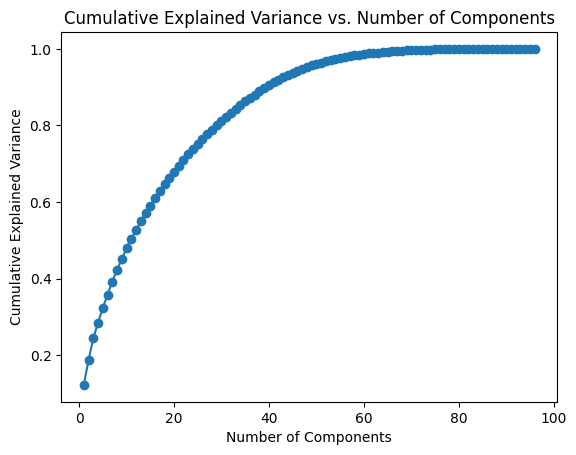

The optimal number of components is: 34


In [343]:
pca = PCA()
pca.fit(X_std_imputed)
explained_var = pca.explained_variance_ratio_

# Assuming you have already obtained the explained variance
cumulative_explained_var = np.cumsum(explained_var)

# Plot the cumulative explained variance
plt.plot(range(1, len(cumulative_explained_var) + 1), cumulative_explained_var, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.show()

# Find the index corresponding to the elbow point
elbow_index = np.argmax(np.diff(cumulative_explained_var) < 0.01) + 1
optimal_components = elbow_index + 1  # Add 1 because indexing starts from 1

print(f"The optimal number of components is: {optimal_components}")


In [344]:
# Apply PCA
pca = PCA(n_components=34)
X_pca = pca.fit_transform(X_std_imputed)

# Create a new dataframe with the PCA components
pca_df = pd.DataFrame(data=X_pca)

# Display the first few rows of the encoded dataframe
print(pca_df.head())

         0         1         2         3         4         5         6   \
0 -0.829234 -0.899813  0.614982  0.208528 -3.731002 -0.328127 -1.250502   
1 -0.270588 -0.928411  0.710756 -2.750664  3.119984  0.702975 -0.334243   
2 -0.096890 -1.085352  0.564338 -2.751997  2.957741 -0.849151 -1.016629   
3 -0.629588 -0.722229  0.168073 -0.043955 -1.421152 -0.268427  0.150975   
4  0.259674 -1.072523  0.881407 -3.578861  2.885815 -0.358753 -2.562259   

         7         8         9   ...        24        25        26        27  \
0 -0.647325 -2.216353  0.442874  ...  0.063780 -1.036369 -0.482517 -0.309474   
1 -1.612180 -1.738092 -1.089845  ... -0.375940 -0.969332  1.442892 -0.925113   
2 -1.161613 -0.823731 -0.491921  ...  0.380341  0.166759 -0.009464 -1.465617   
3 -0.161931 -0.497073 -0.433159  ... -1.574132 -2.381362 -0.202588  0.507138   
4 -0.948775 -1.227035 -1.178671  ... -2.697054  4.007165 -0.298722  0.958537   

         28        29        30        31        32        33  
0 -0

# Task 6 - Clustering

In this chapter, we will explore two clustering methods: the kMeans clustering method and the more advanced OPTICS clustering method. 🤖🔍

## K-Means Clustering

K-Means clustering is a widely used method for grouping data points. In our case, it is applied to cluster restaurants in Kiel based on their latitude and longitude. Here's why K-Means is suitable for this use case:

- **Simplicity and Efficiency:** K-Means is computationally efficient and easy to implement, making it suitable for large datasets. 💻⚡

- **Well-Separated Clusters:** If the underlying structure of the data consists of well-separated, spherical clusters, K-Means tends to perform well. 🌐🔄

## OPTICS Clustering

OPTICS (Ordering Points To Identify the Clustering Structure) is a more advanced clustering method that takes into account the density structure of the data. Here's why OPTICS is suitable for our use case:

- **Density-Based Clustering:** OPTICS is particularly effective in identifying clusters of varying shapes and sizes, making it robust in the presence of noise and outliers. 📊👥

- **Hierarchical Structure:** OPTICS reveals the hierarchical structure of the data, providing insights into the density connectivity of points. 🌳🔗

## Differences and Synergy

While both K-Means and OPTICS are used for clustering, they have key differences:

- **Cluster Shape Sensitivity:** K-Means assumes spherical clusters, whereas OPTICS is more flexible and can handle clusters of varying shapes. 🔄🔵

- **Hierarchical vs. Partitional:** K-Means assigns each point to a single cluster (partitional), while OPTICS unveils a hierarchical clustering structure. 🏰🔍

- **Handling Noise:** OPTICS is robust to noise and outliers due to its density-based approach, while K-Means can be sensitive to outliers. 🚫📈

Understanding the strengths and weaknesses of each method allows us to leverage their complementary aspects. In practice, combining K-Means and OPTICS can provide a more comprehensive view of the data's clustering structure, addressing different patterns and nuances. 🤝🌐


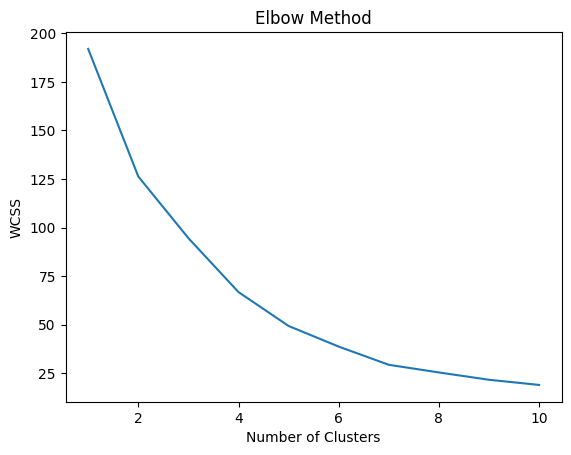

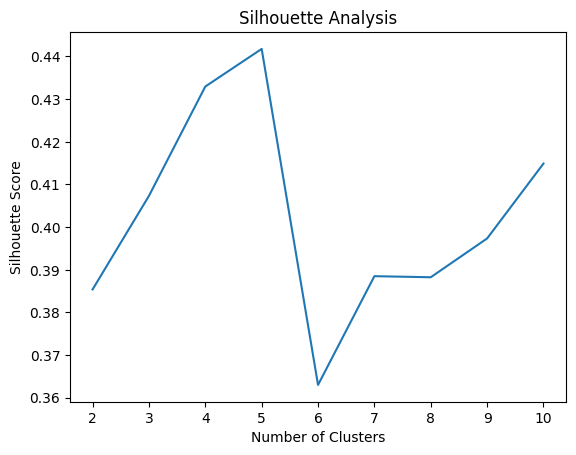

The silhouette score for the best cluster is: 0.44176858374157035


In [345]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Select the columns of interest
selected_columns = data[["lat", "lon"]]

# Standardize the data
scaler = StandardScaler()
selected_columns_scaled = scaler.fit_transform(selected_columns)

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
selected_columns_pca = pca.fit_transform(selected_columns_scaled)

# Perform elbow method to find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(selected_columns_pca)
    wcss.append(kmeans.inertia_)

# Plot the elbow method
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Perform silhouette analysis
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(selected_columns_pca)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(selected_columns_pca, labels))

# Plot silhouette scores
plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Analysis')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# returning the silhouette score for the best cluster
print("The silhouette score for the best cluster is: " + str(max(silhouette_scores)))

Based on our rule of Thumb a Silhouette score from 0 till 0.5 is not that good since the clusters do not seperate that good.
Anyway for demonstration purposes we are going to use them in this notebook.

In [346]:
# Apply K-means clustering to the dataset
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select only the numeric columns (lat and lon)
restaurants_kiel_numeric = data[['lat', 'lon']].dropna()

# Standardize the numeric columns
scaler = StandardScaler()
restaurants_kiel_scaled = scaler.fit_transform(restaurants_kiel_numeric)

# Apply K-means clustering
kmeans = KMeans(n_clusters=5, random_state=0).fit(restaurants_kiel_scaled)

# Add the cluster labels to the dataframe
data['clusterKMeans'] = kmeans.labels_

/home/mbrucker/sem1/sem1_math_and_stats/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [347]:
from sklearn.cluster import OPTICS

# Select only the numeric columns (lat and lon)
restaurants_kiel_numeric = data[['lat', 'lon']]

# Standardize the numeric columns
scaler = StandardScaler()
restaurants_kiel_scaled = scaler.fit_transform(restaurants_kiel_numeric)

# Apply OPTICS clustering
optics = OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.05)
optics.fit(restaurants_kiel_scaled)

# Add the cluster labels to the dataframe
data['clusterOptics'] = optics.labels_

In [348]:
# do some OPTICS clustering with pca_df

# Apply OPTICS clustering
optics = OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.05)
optics.fit(pca_df)

# Add the cluster labels to the dataframe
data['clusterOpticsPCA'] = optics.labels_


# Task 7 - Cluster Interpretation

In [349]:
import folium
# Create a map centered around Kiel
m = folium.Map(location=[54.3233, 10.1228], zoom_start=13)

# Define a color map for the clusters
cluster_colors = {0: 'blue', 1: 'green', 2: 'red', 3: 'purple', 4: 'orange'}

# Add markers for each restaurant with cluster color
for index, row in data.iterrows():
    folium.CircleMarker([row['lat'], row['lon']], radius=5, color=cluster_colors[row['clusterKMeans']], fill=True, fill_color=cluster_colors[row['clusterKMeans']]).add_to(m)

# Display the map
m

The siluette score of 0.44 at 6 clusters isnt the best 

In [350]:
# Create a map centered around Kiel
m = folium.Map(location=[54.3233, 10.1228], zoom_start=13)

# Define a color map for the clusters using seaborn color_palette
num_clusters = len(set(data['clusterOptics']))
cluster_colors = sns.color_palette("husl", num_clusters).as_hex()

# Add markers for each restaurant with cluster color
for index, row in data.iterrows():
    folium.CircleMarker([row['lat'], row['lon']], radius=5, color=cluster_colors[row['clusterOptics']], fill=True, fill_color=cluster_colors[row['clusterOptics']]).add_to(m)

# Display the map
m


### differences between kmeans and OPTICS

first of all when watching the graph you can see on first clance that the diferent clustering mehtodes choosed another ammount of clusters
There are 5 different k means cluster and 9 different optics cluster.

as shown in the maps above, you can really see the differences between kmeans and OPTICS by how they create clusters.
For example with optics all outside clusters are grouped in once single cluster while with k means 



OPTICS 
https://dl.acm.org/doi/pdf/10.1145/304181.304187

In [351]:
# Create a map centered around Kiel
m = folium.Map(location=[54.3233, 10.1228], zoom_start=13)

# Define a color map for the clusters using seaborn color_palette
num_clusters = len(set(data['clusterOpticsPCA']))
cluster_colors = sns.color_palette("husl", num_clusters).as_hex()

# Add markers for each restaurant with cluster color
for index, row in data.iterrows():
    folium.CircleMarker([row['lat'], row['lon']], radius=5, color=cluster_colors[row['clusterOpticsPCA']], fill=True, fill_color=cluster_colors[row['clusterOpticsPCA']]).add_to(m)

# Display the map
m


on first glance the clusters based on all attributes cant be seen on a 2d representation of the lat and lon variable

In [352]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(pca_df, data['clusterOpticsPCA'])
print(f"Silhouette Score: {silhouette_avg}")

from sklearn.metrics import calinski_harabasz_score
calinski_harabasz = calinski_harabasz_score(pca_df, data['clusterOpticsPCA'])
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

from sklearn.metrics import davies_bouldin_score
davies_bouldin = davies_bouldin_score(pca_df, data['clusterOpticsPCA'])
print(f"Davies-Bouldin Index: {davies_bouldin}")

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(pca_df)
inertia = kmeans.inertia_
print(f"Inertia: {inertia}")


Silhouette Score: -0.008963249916551628
Calinski-Harabasz Index: 1.4979907133929211
Davies-Bouldin Index: 5.300997653709353
Inertia: 8200.318749700553


/home/mbrucker/sem1/sem1_math_and_stats/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


1. **Silhouette Score: -0.00896** 😕
   - The negative silhouette score suggests that the clusters might be overlapping, and objects could be assigned to the wrong cluster. A positive silhouette score is typically desired.

2. **Calinski-Harabasz Index: 1.498** 😐
   - The relatively low Calinski-Harabasz index indicates that the clusters may not be well-separated. Higher values are preferred for better-defined clusters.

3. **Davies-Bouldin Index: 5.301** 😬
   - The Davies-Bouldin index suggests that the clusters are not well-separated and may not be very compact. Lower values are generally better, indicating room for improvement.

4. **Inertia: 8200.32** 🤔
   - The inertia value is a raw measure of total distance within clusters. Without a reference point, it's not immediately clear how good or bad this value is. You might compare it to other clusterings or use it as a baseline for improvement.

**Interpretation Summary:** 📊
All this combined shows that 


# Task 8 - Conclusion and Future Work

On basis of the data i would reccomend the new enterprise to be open


Improvements that could be made:
Sure thing, the better the data basis the more analysis is possible to be done with the data. As presentet there are many attributes that are filled wit NAN values, with a broader participation in the open street map community further analysis would be possible to be done.

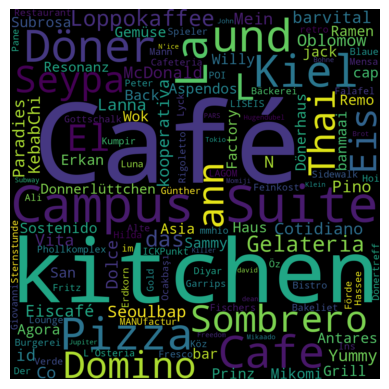

In [353]:
# Libraries
# !pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a list of word
text = data["name"].to_string()

# Create the wordcloud object
wordcloud = WordCloud(width=1080, height=1080, margin=0).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# SE GRAVE FOR FORGOTTEN COMANDS

# Cleaning the data

In [354]:
# Since alot of attributes are only available for a few restaurants, we will drop them

# we will drop attributes that are represented in less than 80% of the data
# the following how to calculate the percentage of na values in a column

print("For a attribute to be represented in 80 of the data, it can only have " + str(len(data) * 0.8) + " na values")

# drop colums with more than 20% na values
data.dropna(thresh=(len(data) * 0.8), axis=1, inplace=True)

For a attribute to be represented in 80 of the data, it can only have 76.80000000000001 na values


In [355]:
data.isna().sum().sort_values(ascending=True).head(25)

lat                  0
lon                  0
amenity              0
name                 0
clusterOptics        0
clusterKMeans        0
clusterOpticsPCA     0
opening_hours        5
wheelchair          13
dtype: int64

In [356]:
# Analysing how many unique values each column has to get the value of the individual column

print("The ammount of unique values in each column is:")
data.nunique().sort_values(ascending=True).head(25)


The ammount of unique values in each column is:


clusterOpticsPCA     2
wheelchair           3
clusterKMeans        5
amenity              5
clusterOptics        9
opening_hours       87
name                90
lat                 96
lon                 96
dtype: int64

## Removing Outliners

Removing outliners based on lat and lon



In [357]:
import seaborn as sns

/tmp/ipykernel_682/3392433084.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data["lat"])
/tmp/ipykernel_682/3392433084.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data["lon"])


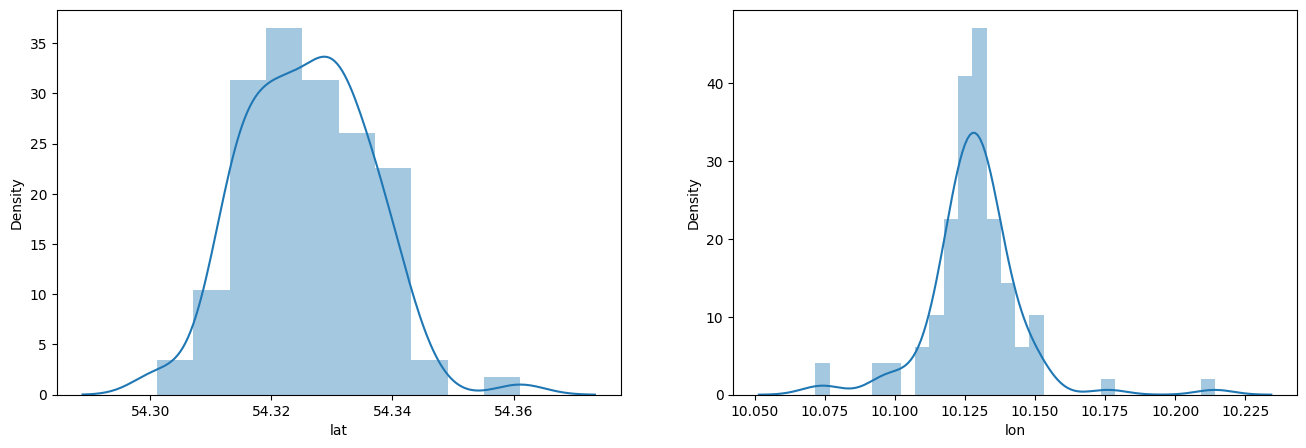

In [358]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(data["lat"])
plt.subplot(1,2,2)
sns.distplot(data["lon"])
plt.show()

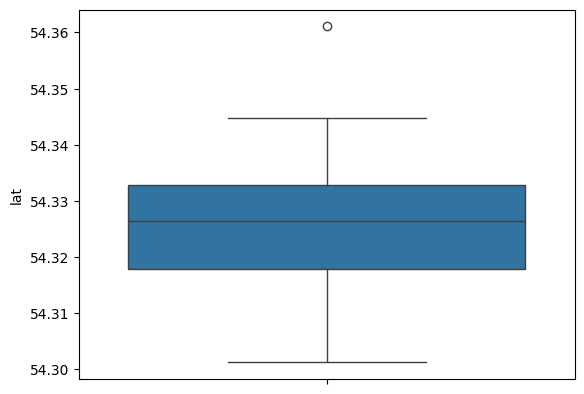

<Axes: ylabel='lon'>

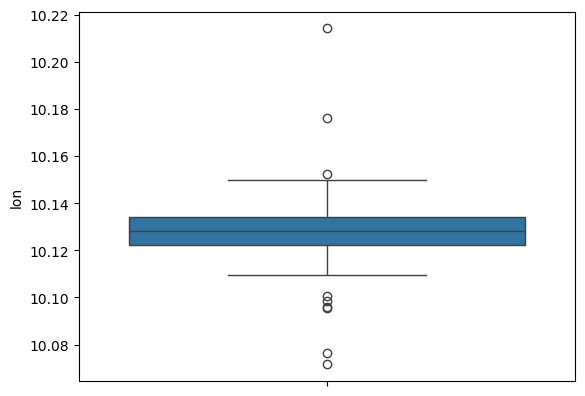

In [359]:
sns.boxplot(data['lat'])
plt.show()
sns.boxplot(data['lon'])

In [360]:
percentile25 = data['lat'].quantile(0.25)
percentile75 = data['lat'].quantile(0.75)

# Data visualization

<Axes: ylabel='count'>

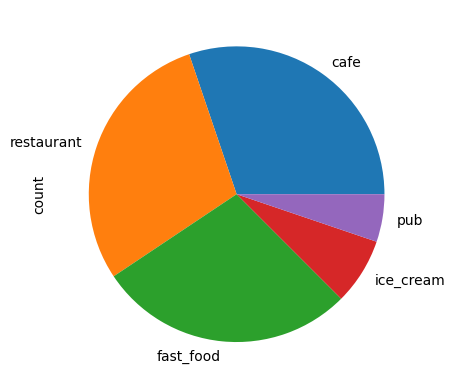

In [361]:
# the distribution of amenity as a pie chart

data["amenity"].value_counts().plot.pie()

In [362]:
# the distribution of cuisine as a pie chart

data_raw["cuisine"].value_counts().plot.pie()

NameError: name 'data_raw' is not defined

<Axes: ylabel='count'>

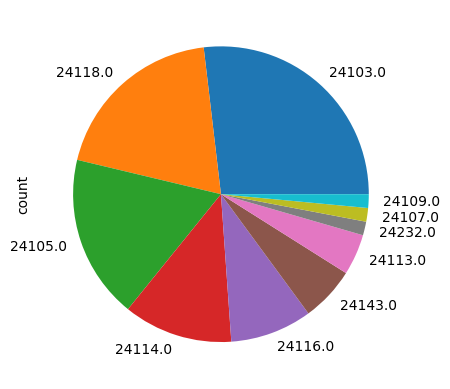

In [ ]:
# display more information about the dataset

data_raw["addr:postcode"].value_counts().plot.pie()

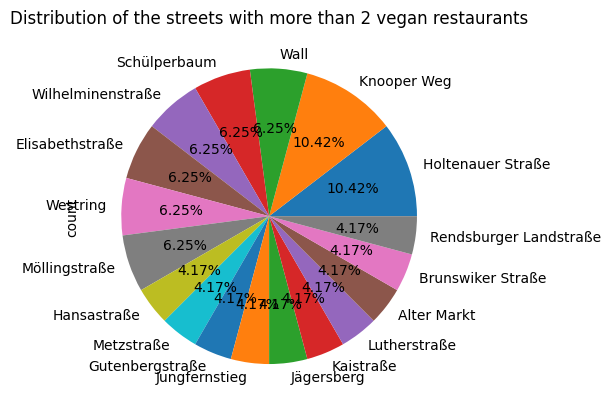

In [ ]:
# only return the values that are represented 2 or more times

# Only return the values that are represented 2 or more times
data_filtered = data["addr:street"].value_counts()[data["addr:street"].value_counts() >= 2]

# Plot the pie chart with labels
data_filtered.plot.pie(autopct="%1.2f%%")
plt.title("Distribution of the streets with more than 2 vegan restaurants")
plt.show()

<Axes: ylabel='count'>

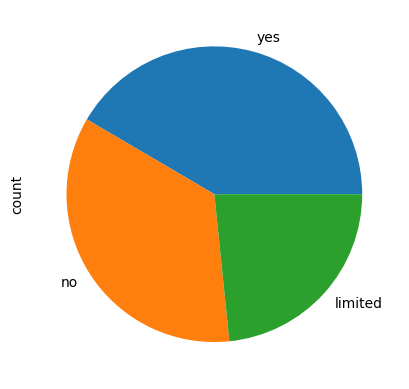

In [ ]:
data["wheelchair"].value_counts().plot.pie()

# Clustering

By the rule of thumb a silhouette score is between 0.5 ≥ sC > 0.25 so we have a weak structure wich is close to a usable structure

In [ ]:
# itterate trough the clusters and print the number of data instances

for cluster in range(n_clusters):
    cluster_data = data[data['cluster'] == cluster]
    print(f'Cluster {cluster + 1}: {cluster_data.shape[0]} data instances')


# Source of Code: 06_2_clans_iris.ipynb

Cluster 1: 26 data instances
Cluster 2: 38 data instances
Cluster 3: 5 data instances
Cluster 4: 2 data instances
Cluster 5: 24 data instances
Cluster 6: 1 data instances


# Removing Outlayers:

In [ ]:
# drop rows with the clusters 3 4 and 6

data.drop(data[data["cluster"] == 2].index, inplace=True)
data.drop(data[data["cluster"] == 3].index, inplace=True)
data.drop(data[data["cluster"] == 5].index, inplace=True)

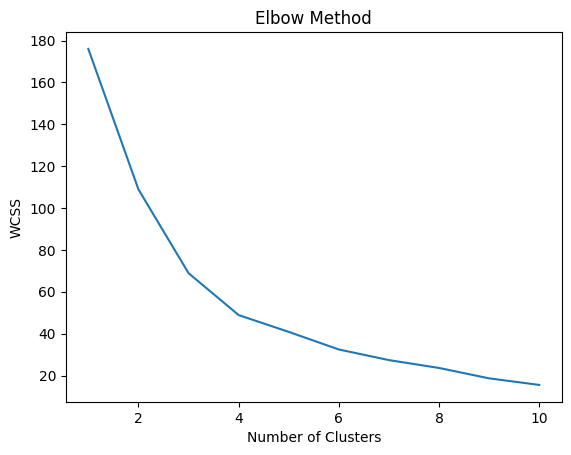

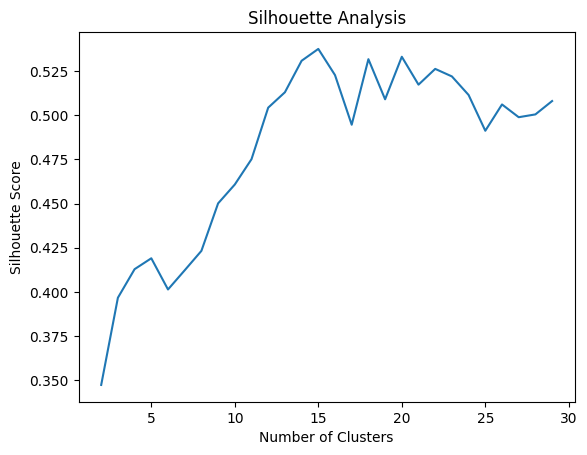

The silhouette score for the best cluster is: 0.5374083718130481


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Select the columns of interest
selected_columns = data[["lat", "lon"]]

# Standardize the data
scaler = StandardScaler()
selected_columns_scaled = scaler.fit_transform(selected_columns)

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
selected_columns_pca = pca.fit_transform(selected_columns_scaled)

# Perform elbow method to find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(selected_columns_pca)
    wcss.append(kmeans.inertia_)

# Plot the elbow method
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Perform silhouette analysis
silhouette_scores = []
for i in range(2, 30):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(selected_columns_pca)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(selected_columns_pca, labels))

# Plot silhouette scores
plt.plot(range(2, 30), silhouette_scores)
plt.title('Silhouette Analysis')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# returning the silhouette score for the best cluster
print("The silhouette score for the best cluster is: " + str(max(silhouette_scores)))

/home/mbrucker/sem1/sem1_math_and_stats/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


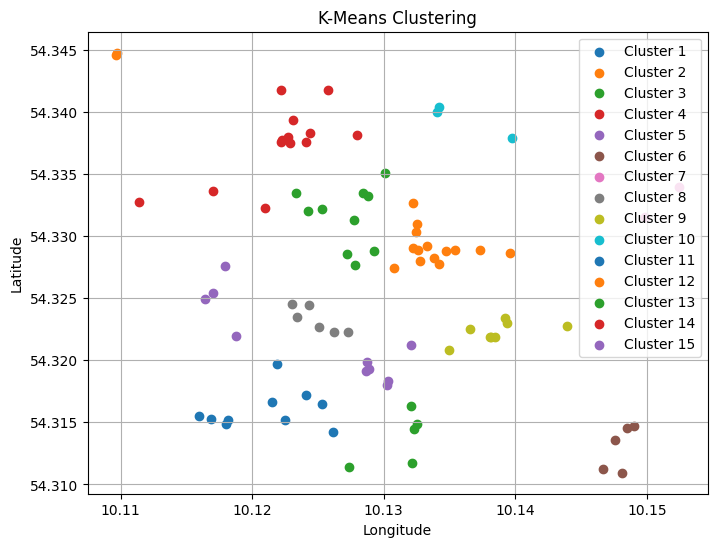

In [ ]:
# Define the number of clusters (you can use the result from the elbow method)
n_clusters = 15

# Perform K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(selected_columns_scaled)

# Add cluster labels to the DataFrame
data['cluster'] = kmeans.labels_

# Create a scatter plot with clusters
plt.figure(figsize=(8, 6))
for cluster in range(n_clusters):
    cluster_data = data[data['cluster'] == cluster]
    plt.scatter(cluster_data['lon'], cluster_data['lat'], label=f'Cluster {cluster + 1}')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-Means Clustering')
plt.legend()
plt.grid(True)
plt.show()


# Analyzing the Clusters

In [ ]:
# return the unique sum of amenitys inside each cluster name the type of amiety

for cluster in range(n_clusters):
    cluster_data = data[data['cluster'] == cluster]
    print(f'Cluster {cluster + 1}: {cluster_data["amenity"].unique()}')

Cluster 1: ['cafe', 'fast_food', 'pub', 'restaurant', 'ice_cream']
Categories (5, object): ['cafe', 'fast_food', 'ice_cream', 'pub', 'restaurant']
Cluster 2: ['fast_food', 'cafe', 'restaurant', 'pub', 'ice_cream']
Categories (5, object): ['cafe', 'fast_food', 'ice_cream', 'pub', 'restaurant']
Cluster 3: ['fast_food', 'restaurant', 'ice_cream']
Categories (5, object): ['cafe', 'fast_food', 'ice_cream', 'pub', 'restaurant']
Cluster 4: ['fast_food']
Categories (5, object): ['cafe', 'fast_food', 'ice_cream', 'pub', 'restaurant']
Cluster 5: ['restaurant', 'cafe', 'fast_food', 'ice_cream']
Categories (5, object): ['cafe', 'fast_food', 'ice_cream', 'pub', 'restaurant']
Cluster 6: ['fast_food']
Categories (5, object): ['cafe', 'fast_food', 'ice_cream', 'pub', 'restaurant']


## Geografische beschreibung der Cluster

- Cluster 1 Bahnhof
- Cluster 2 Innenstadt
- Cluster 3 Hassee
- Cluster 4 Schönkirchen
- Cluster 5 Universität